In [2]:
import pandas as pd
import scipy.signal
import seaborn as sns

In [3]:
path = "/home/francisco/tps/datos/tp2/"
load_path = path + "dataframe_reconstruido_{}.hdf"

N = 2
pacientes = []
for paciente in range(1, 1 + N):
    pacientes.append(pd.read_hdf(load_path.format(paciente)))


In [4]:
p1 = pacientes[0]

df1 = p1.loc[1,:,[8,44,80,131,185],:]

In [5]:
sensor_means = df1.groupby(['epoch', 'tiempo']).mean()
print(sensor_means)

                   valores
epoch tiempo              
0     0      -1.502726e-06
      1       2.484056e-08
      2       2.153763e-06
      3       3.866775e-06
      4       4.267342e-06
      5       3.403688e-06
      6       2.164760e-06
      7       1.326449e-06
      8       8.867810e-07
      9       4.527821e-07
      10      5.964371e-08
      11      2.290245e-07
      12      1.119029e-06
      13      1.944402e-06
      14      1.646868e-06
      15      1.894892e-07
      16     -1.149500e-06
      17     -1.090785e-06
      18      7.944991e-08
      19      5.735424e-07
      20     -1.039852e-06
      21     -4.123359e-06
      22     -6.366552e-06
      23     -6.026844e-06
      24     -3.697938e-06
      25     -1.716725e-06
      26     -1.813764e-06
      27     -3.464750e-06
      28     -4.612813e-06
      29     -3.899714e-06
...                    ...
893   171     6.590707e-06
      172     5.014532e-06
      173     4.228430e-06
      174     4.377399e-06
 

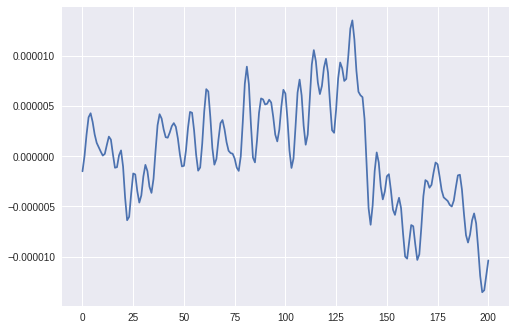

[ 0.]

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]

/home/francisco/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  .format(nperseg, input_length))


In [21]:
# frecuencias = sensor_means.groupby(['epoch']).apply(lambda x: scipy.signal.welch(x, fs=130.52, nperseg = 130.52))
frecuencias = sensor_means.groupby(['epoch']).apply(lambda x: x.shape)
x = sensor_means.loc[0,:]
sns.plt.plot(x)
sns.plt.show()

f, y = scipy.signal.welch(x)
print(f)
print()
print(y):w

In [ ]:
df_prueba = pd.DataFrame({'valores': [20,1,21,2]}, index=pd.MultiIndex.from_arrays([[1,1,2,2], [1,2,1,2]], names=['a', 'tiempo']))
print(df_prueba)
df_prueba.groupby(['tiempo']).mean()

In [ ]:
# means = pacientes[0].groupby(['epoch','tiempo']).mean()
pacientes[0].groupby(['epoch','tiempo'])

In [ ]:
ps = []
for index_epoch in range(len(means.index.levels[0])):
    f,p = scipy.signal.welch(means.loc[index_epoch]['valores'],fs=130.52, nperseg = 130.52)
    ps.append(p)

In [ ]:
ps = np.matrix(ps).transpose()
ax = sns.heatmap(ps,vmin=0, vmax=(10**(-11)))

In [ ]:
sns.plt.show()